## 1. Installing the packages

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import re
from tensorflow.python.keras import backend
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

## 2. Cleaning the Data

In [3]:
from google.colab import drive #Dataset mounted from google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/poddf.csv')

In [5]:
df

,index,Name,Rating_Volume,Rating,Genre,Description
0,0,Fresh Air,10188,4.46133,Arts,"Fresh Air from WHYY, the Peabody Award-winning..."
1,0,The Moth,10154,4.69982,Performing,"Since its launch in 1997, The Moth has present..."
2,0,99% Invisible,12303,4.8693,Design,"Design is everywhere in our lives, perhaps mos..."
3,0,iFanboy.com Comic Book Podcast,1335,4.79551,Visual,The iFanboy.com Comic Book Podcast is a weekly...
4,0,Myths and Legends,11128,4.88282,Literature,"Jason Weiser tells stories from myths, legends..."
...,...,...,...,...,...,...
13627,0,Puromac,166,4.87952,Tech News,Puromac es una conversación sobre todo el mund...
13628,0,AVexcel,51,4.84314,Tech News,AVexcel is your guide to the best in home thea...
13629,0,Take a Network Break And Get The Latest Networ...,64,4.95313,Tech News,"Stay current with IT news on vendor moves, new..."
13630,0,AVexcel,52,4.82692,Tech News,AVexcel is your guide to the best in home thea...


In [6]:
df.Genre.value_counts().head(10) #visualizing top 10 genres

Business News             249
Investing                 245
Comedy                    244
Tech News                 243
Places & Travel           242
History                   241
Educational Technology    241
Video Games               241
Design                    241
Literature                240
Name: Genre, dtype: int64

In [7]:
df.Rating.value_counts().head(5)

Not Found    1887
5.0           702
4.5           144
4.66667       121
4.0           117
Name: Rating, dtype: int64

In [9]:
temp1=df[df["Genre"] == "Literature"]
temp2=df[df["Genre"] == "Business News"]
temp3=df[df["Genre"] == "Comedy"]
temp4=df[df["Genre"] == "History"]
temp5=df[df["Genre"] == "Places & Travel"]

In [10]:
merged_df = pd.concat([temp1, temp2, temp3,temp4,temp5]) #merge only 5 genres for better accuracy

In [11]:
merged_df.Genre.value_counts()

Business News      249
Comedy             244
Places & Travel    242
History            241
Literature         240
Name: Genre, dtype: int64

In [12]:
df=merged_df

In [13]:
df

,index,Name,Rating_Volume,Rating,Genre,Description
4,0,Myths and Legends,11128,4.88282,Literature,"Jason Weiser tells stories from myths, legends..."
8,0,The New Yorker: Fiction,1039,4.48412,Literature,A monthly reading and conversation with the Ne...
14,0,The NoSleep Podcast,5116,4.77853,Literature,The NoSleep Podcast is a multi-award winning a...
18,0,The Book Review,692,4.13295,Literature,The world's top authors and critics join host ...
21,0,MuggleCast: the Harry Potter podcast,2263,4.6814,Literature,MuggleCast is the most-listened to Harry Potte...
...,...,...,...,...,...,...
11392,0,The Vegas Tourist Podcast,9,2.44444,Places & Travel,Mark Anthony - Your podcast guide to Las Vegas...
11393,0,Disney Hipster Podcast,243,4.61728,Places & Travel,A podcast critiquing the aesthetic choices of ...
11394,0,Drinky Fun Time,88,4.84091,Places & Travel,It’s about drinking. Featuring celebrity guest...
11395,0,Capture The Magic - Disney World Podcast | Dis...,91,4.81318,Places & Travel,The Capture The Magic Podcast is a fun and inf...


In [14]:
df=merged_df.reset_index(drop=True) #reset the starting index from 0

In [15]:
df

,index,Name,Rating_Volume,Rating,Genre,Description
0,0,Myths and Legends,11128,4.88282,Literature,"Jason Weiser tells stories from myths, legends..."
1,0,The New Yorker: Fiction,1039,4.48412,Literature,A monthly reading and conversation with the Ne...
2,0,The NoSleep Podcast,5116,4.77853,Literature,The NoSleep Podcast is a multi-award winning a...
3,0,The Book Review,692,4.13295,Literature,The world's top authors and critics join host ...
4,0,MuggleCast: the Harry Potter podcast,2263,4.6814,Literature,MuggleCast is the most-listened to Harry Potte...
...,...,...,...,...,...,...
1211,0,The Vegas Tourist Podcast,9,2.44444,Places & Travel,Mark Anthony - Your podcast guide to Las Vegas...
1212,0,Disney Hipster Podcast,243,4.61728,Places & Travel,A podcast critiquing the aesthetic choices of ...
1213,0,Drinky Fun Time,88,4.84091,Places & Travel,It’s about drinking. Featuring celebrity guest...
1214,0,Capture The Magic - Disney World Podcast | Dis...,91,4.81318,Places & Travel,The Capture The Magic Podcast is a fun and inf...


In [16]:
def print_plot(index):
    example = df[df.index == index][['Description', 'Genre']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Genre:', example[1])
print_plot(60) #print description and genre at this index

ALOUD is the Library Foundation of Los Angeles' award-winning literary series of live conversations, readings and performances at the historic Central Library and locations throughout Los Angeles.
Genre: Literature


In [17]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
df['Description']

0       Jason Weiser tells stories from myths, legends...
1       A monthly reading and conversation with the Ne...
2       The NoSleep Podcast is a multi-award winning a...
3       The world's top authors and critics join host ...
4       MuggleCast is the most-listened to Harry Potte...
                              ...                        
1211    Mark Anthony - Your podcast guide to Las Vegas...
1212    A podcast critiquing the aesthetic choices of ...
1213    It’s about drinking. Featuring celebrity guest...
1214    The Capture The Magic Podcast is a fun and inf...
1215    RV Miles is a podcast for anyone interested in...
Name: Description, Length: 1216, dtype: object

In [19]:
df = df.reset_index(drop=True)
replace_by_space = re.compile('[/(){}\[\]\|@,;]')
bad_symbols = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):

    text = text.lower() # lowercase text
    text = replace_by_space.sub(' ', text) # replace 'replace_by_space' symbols by space in text and substitute the matched string with space.
    text = bad_symbols.sub('', text) # remove symbols which are in 'bad_symbols' from text and substitute the matched string with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text
df['Description'] = df['Description'].apply(clean_text)
df['Description'] = df['Description'].str.replace('\d+', '')

In [20]:
df

,index,Name,Rating_Volume,Rating,Genre,Description
0,0,Myths and Legends,11128,4.88282,Literature,jason weiser tells stories myths legends folkl...
1,0,The New Yorker: Fiction,1039,4.48412,Literature,monthly reading conversation new yorker fictio...
2,0,The NoSleep Podcast,5116,4.77853,Literature,nosleep podcast multiaward winning anthology s...
3,0,The Book Review,692,4.13295,Literature,worlds top authors critics join host pamela pa...
4,0,MuggleCast: the Harry Potter podcast,2263,4.6814,Literature,mugglecast mostlistened harry potter podcast h...
...,...,...,...,...,...,...
1211,0,The Vegas Tourist Podcast,9,2.44444,Places & Travel,mark anthony podcast guide las vegas beyond he...
1212,0,Disney Hipster Podcast,243,4.61728,Places & Travel,podcast critiquing aesthetic choices disney co...
1213,0,Drinky Fun Time,88,4.84091,Places & Travel,drinking featuring celebrity guests hosts dan ...
1214,0,Capture The Magic - Disney World Podcast | Dis...,91,4.81318,Places & Travel,capture magic podcast fun informative show dis...


In [21]:
df['Description'].values

array(['jason weiser tells stories myths legends folklore shaped cultures throughout history like stories aladdin king arthur hercules stories think know surprising origins others stories might heard really stories sourced world folklore retold modern earsthese stories wizards knights vikings dragons princesses kings time world beyond map dangerous wonderful place',
       'monthly reading conversation new yorker fiction editor deborah treisman',
       'nosleep podcast multiaward winning anthology series original horror stories rich atmospheric music enhance frightening tales',
       ...,
       'drinking featuring celebrity guests hosts dan dunn emma patterson mention drinking',
       'capture magic podcast fun informative show discuss aspects planning disney vacation latest disney related news disney trip reports disney tips tricks rumors',
       'rv miles podcast anyone interested rv camping lifestyle news reviews destinations recipes much rolling road motorhome trailer fifth wh

## 3. LSTM Modelling

In [22]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 10530 unique tokens.


In [23]:
X = tokenizer.texts_to_sequences(df['Description'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1216, 250)


In [24]:
X

array([[   0,    0,    0, ..., 1725,  598,  182],
       [   0,    0,    0, ...,  426, 4466, 4467],
       [   0,    0,    0, ..., 1727, 2897,  105],
       ...,
       [   0,    0,    0, ..., 2761, 3354, 1192],
       [   0,    0,    0, ...,   55,  707, 1721],
       [   0,    0,    0, ..., 4328, 1822,  335]], dtype=int32)

In [25]:
df

,index,Name,Rating_Volume,Rating,Genre,Description
0,0,Myths and Legends,11128,4.88282,Literature,jason weiser tells stories myths legends folkl...
1,0,The New Yorker: Fiction,1039,4.48412,Literature,monthly reading conversation new yorker fictio...
2,0,The NoSleep Podcast,5116,4.77853,Literature,nosleep podcast multiaward winning anthology s...
3,0,The Book Review,692,4.13295,Literature,worlds top authors critics join host pamela pa...
4,0,MuggleCast: the Harry Potter podcast,2263,4.6814,Literature,mugglecast mostlistened harry potter podcast h...
...,...,...,...,...,...,...
1211,0,The Vegas Tourist Podcast,9,2.44444,Places & Travel,mark anthony podcast guide las vegas beyond he...
1212,0,Disney Hipster Podcast,243,4.61728,Places & Travel,podcast critiquing aesthetic choices disney co...
1213,0,Drinky Fun Time,88,4.84091,Places & Travel,drinking featuring celebrity guests hosts dan ...
1214,0,Capture The Magic - Disney World Podcast | Dis...,91,4.81318,Places & Travel,capture magic podcast fun informative show dis...


In [26]:
Y = pd.get_dummies(df['Genre']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1216, 5)


In [27]:
Y

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 7)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1094, 250) (1094, 5)
(122, 250) (122, 5)


In [29]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/10
31/31 [==============================] - 23s 615ms/step - loss: 1.6070 - accuracy: 0.2223 - val_loss: 1.5791 - val_accuracy: 0.4000
Epoch 2/10
31/31 [==============================] - 18s 593ms/step - loss: 1.4978 - accuracy: 0.5395 - val_loss: 1.2399 - val_accuracy: 0.4727
Epoch 3/10
31/31 [==============================] - 18s 593ms/step - loss: 1.0050 - accuracy: 0.6682 - val_loss: 0.9645 - val_accuracy: 0.6273
Epoch 4/10
31/31 [==============================] - 18s 593ms/step - loss: 0.5759 - accuracy: 0.8612 - val_loss: 0.8340 - val_accuracy: 0.7182
Epoch 5/10
31/31 [==============================] - 18s 595ms/step - loss: 0.3491 - accuracy: 0.9201 - val_loss: 0.8281 - val_accuracy: 0.7364
Epoch 6/10
31/31 [==============================] - 18s 596ms/step - loss: 0.2210 - accuracy: 0.9475 - val_loss: 0.9104 - val_accuracy: 0.6727
Epoch 7/10
31/31 [==============================] - 18s 591ms/step - loss: 0.1654 - accuracy: 0.9613 - val_loss: 0.6944 - val_accuracy: 0.8000

In [30]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/10
16/16 [==============================] - 17s 800ms/step - loss: 1.6077 - accuracy: 0.2472 - val_loss: 1.5926 - val_accuracy: 0.3091
Epoch 2/10
16/16 [==============================] - 12s 778ms/step - loss: 1.5726 - accuracy: 0.4397 - val_loss: 1.5034 - val_accuracy: 0.5364
Epoch 3/10
16/16 [==============================] - 13s 783ms/step - loss: 1.4202 - accuracy: 0.5654 - val_loss: 1.4032 - val_accuracy: 0.5727
Epoch 4/10
16/16 [==============================] - 12s 774ms/step - loss: 1.2190 - accuracy: 0.7244 - val_loss: 1.1929 - val_accuracy: 0.5364
Epoch 5/10
16/16 [==============================] - 12s 779ms/step - loss: 0.9092 - accuracy: 0.7401 - val_loss: 1.0206 - val_accuracy: 0.5818
Epoch 6/10
16/16 [==============================] - 12s 781ms/step - loss: 0.6664 - accuracy: 0.7915 - val_loss: 0.8548 - val_accuracy: 0.7545
Epoch 7/10
16/16 [==============================] - 12s 777ms/step - loss: 0.4260 - accuracy: 0.9117 - val_loss: 0.7715 - val_accuracy: 0.7273

In [32]:
new_summary  = ['I feel really depressed today and want to listen to something funny']
seq = tokenizer.texts_to_sequences(new_summary )
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Literature', 'Business News', 'Comedy' ,'History', 'Places & Travel']
print(pred, labels[np.argmax(pred)])


[[0.09659347 0.252046   0.29401448 0.2513486  0.10599749]] Comedy


In [33]:
new_summary  = ['I feel really unproductive today. Wish I had done more studies']
seq = tokenizer.texts_to_sequences(new_summary )
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Business News','Investing','Comedy','Tech News','Places & Travel']
print(pred, labels[np.argmax(pred)])

[[0.18824348 0.11887355 0.21639197 0.39370492 0.08278609]] Tech News


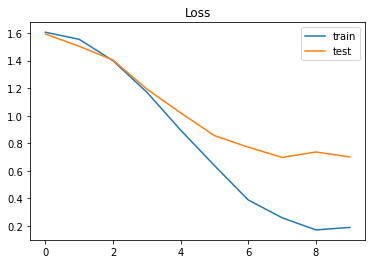

In [34]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

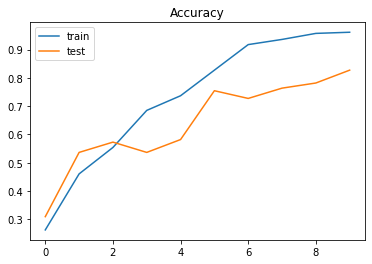

In [35]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## Analyzing emotion of our input text using text2emotion library:




In [36]:
pip install text2emotion

     |████████████████████████████████| 61kB 2.2MB/s 
     |████████████████████████████████| 133kB 5.1MB/s 


In [37]:
import text2emotion as te

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [38]:
text = 'I feel really depressed today and want to listen to something funny'

In [39]:
te.get_emotion(text)

{'Angry': 0.0, 'Fear': 0.0, 'Happy': 0.0, 'Sad': 0.33, 'Surprise': 0.67}

In [40]:
text1 = 'I feel really unproductive today. Wish I had done more studies'

In [41]:
te.get_emotion(text1)

{'Angry': 0.0, 'Fear': 0.0, 'Happy': 0.0, 'Sad': 0.0, 'Surprise': 1.0}